The third edition of *Think Stats* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Estimation

Suppose you live in a town with a population of 10,000 people, and you want to predict who will win an upcoming election.
In theory, you could ask everyone in town who they plan to vote for, and if they all answered honestly, you could make a reliable prediction.

But even in a small town, it is probably not practical to survey the entire population.
Fortunately, is it not necessary.
If you survey a random subset of the people, you can use the sample to infer the voting preferences of the population.
This process -- using a sample to make inferences about a population -- is called statistical inference.

Statistical inference includes estimation, which is the topic of this chapter, and hypothesis testing, which is the topic of the next chapter.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap08.ipynb).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

Downloaded thinkstats.py


In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.8.0-py3-none-any.whl size=12556 sha256=313ead9b960e7781cf1d8eb21f202fb29dc31785b55c2c551ff625147682e213
  Stored in directory: /root/.cache/pip/wheels/ca/a9/1f/90c7a8a37ac37ff0fa0a27b2152f9b24be8910448ab93992f8
Successfully built empiricaldist


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

(section_weighing_penguins)=
## Weighing Penguins

Suppose you are a researcher in Antarctica, studying local populations of penguins.
One of your tasks is to monitor the average weight of the penguins as it varies over the course of the year.
It would be impractical to weigh every penguin in the environment, so your plan is to collect a random sample of 10 penguins each week, weigh them, and use the sample to estimate the mean of the entire population -- which is called the **population mean**.

There are many ways you could use the sample to estimate the population mean, but we'll consider just two: the sample mean and the sample median.
They are both reasonable choices, but let's see which is better -- and think about what we mean by "better".

For purposes of demonstration, we'll assume that penguin weights are drawn from a normal distribution with known mean and standard deviation, which I'll denote `mu` and `sigma` and assign values in kilograms.

In [5]:
mu = 3.7
sigma = 0.46

These values are the **parameters** of the normal distribution, which means that they specify a particular distribution.
Given these parameters, we can use NumPy to simulate the sampling process and generate a sample of any size.
For example, here's a hypothetical sample of 10 weights.

In [6]:
# Seed the random number generator so we get the same results every time
np.random.seed(1)

In [7]:
sample = np.random.normal(mu, sigma, size=10)
sample

array([4.44719887, 3.41859205, 3.45704099, 3.20643443, 4.09808751,
       2.6412922 , 4.50261341, 3.34984483, 3.84675798, 3.58528963])

And here are the mean and median of the sample.

In [8]:
np.mean(sample), np.median(sample)

(3.6553151902291945, 3.521165310619601)

The mean and median are different enough that we should wonder which is a better estimate.
To find out, we'll use the following function to generate hypothetical samples with the given size, `n`.

In [9]:
def make_sample(n):
    return np.random.normal(mu, sigma, size=n)

As a first experiment, let's see how the sample mean and sample median behave as the sample size increases.
We'll use the NumPy function `logspace` to make a range of `ns` from 1 to 10,000, equally spaced on a logarithmic scale.

In [10]:
ns = np.logspace(1, 5).astype(int)

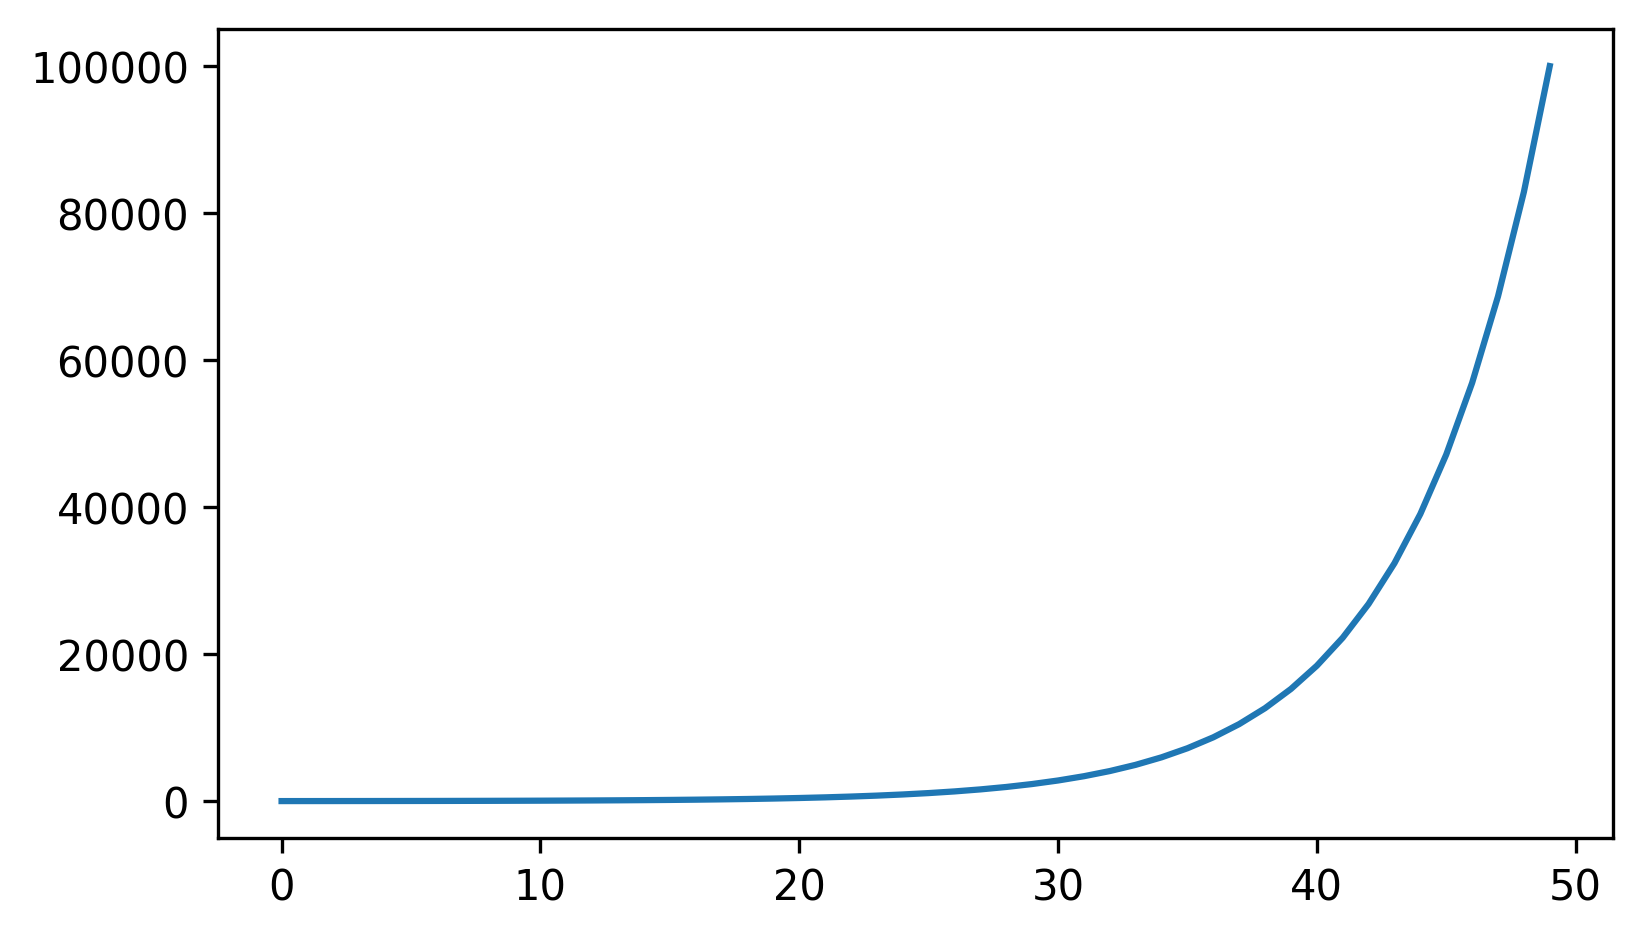

In [13]:
plt.plot(ns)

For each value of `n`, we'll generate a hypothetical sample and compute its mean.

In [14]:
means = [np.mean(make_sample(n)) for n in ns]

And we'll do the same for the median.

In [15]:
medians = [np.median(make_sample(n)) for n in ns]

A statistic, like the sample mean or median, that's used to estimate a property of a population is called an **estimator**.

The following figure shows how these estimators behave as we increase the sample size.
The horizontal line shows the actual mean in the population.

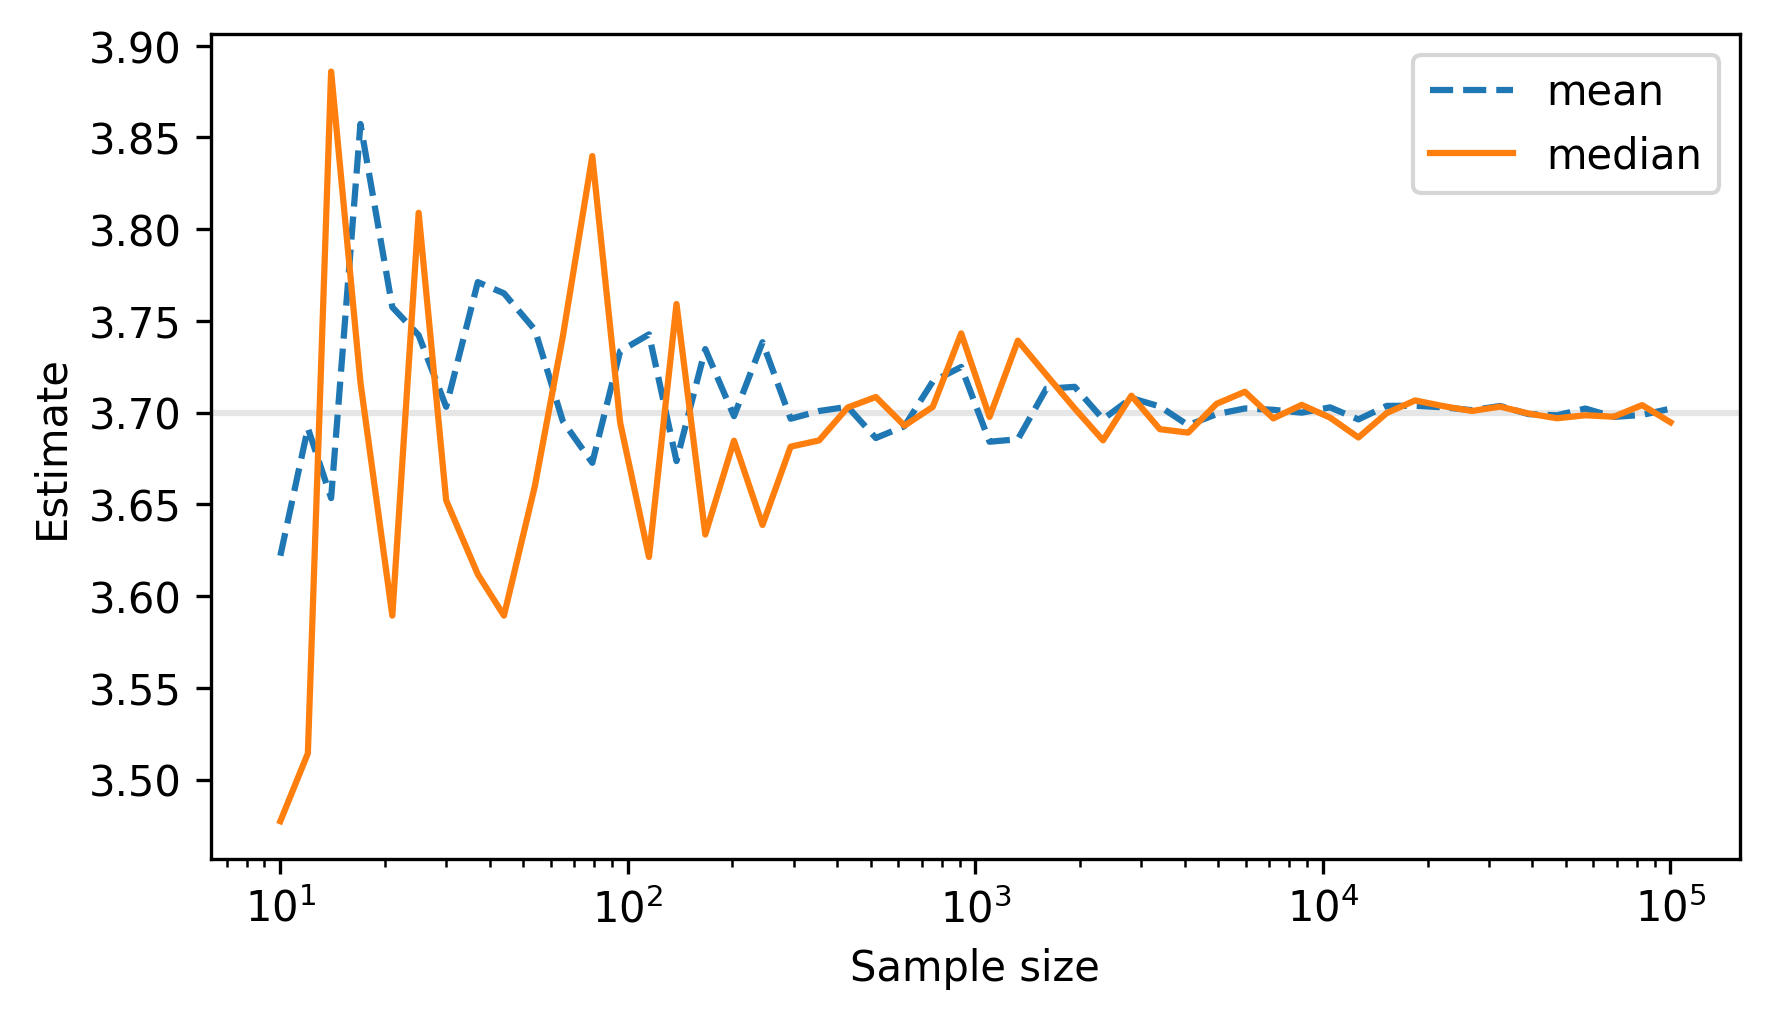

In [16]:
plt.axhline(mu, color="0.9")
plt.plot(ns, means, "--", label="mean")
plt.plot(ns, medians, label="median")

decorate(xlabel="Sample size", xscale="log", ylabel="Estimate")

For both estimators, the estimates converge to the actual value as the sample size increases.
This demonstrates that they are **consistent**, which is one of the properties a good estimator should have.
Based on this property, the mean and median seem equally good.

In the previous figure, you might notice that the estimates are sometimes too high and sometimes too low -- and it looks like the variation is roughly symmetric around the true value.
That suggests another experiment: if we collect many samples with the same size and compute many estimates, what is the average of the estimates?

The following loop simulates this scenario by generating 10,001 samples of 10 penguins and computing the mean of each sample.
Then it uses a list comprehension to collect the results in a list.

In [17]:
means = [np.mean(make_sample(n=10)) for i in range(10001)]
np.mean(means)

3.70034508492869

The average of the means is close to the actual mean we used to generate the samples: 3.7 kg.

The following loop simulates the same scenario, but this time it computes the median of each sample.

In [18]:
medians = [np.median(make_sample(n=10)) for i in range(10001)]
np.mean(medians)

3.701214089907223

The average of these hypothetical medians is also very close to the actual population mean.

These results demonstrate that the sample mean and median are **unbiased** estimators, which means that they are correct on average.
The word "bias" means different things in different contexts, which can be a source of confusion.
In this context, "unbiased" means that the average of the estimates is the actual value.

So far, we've shown that both estimators are consistent and unbiased, but it's still not clear which is better.
Let's try one more experiment: let's see which estimator is more accurate.
The word "accurate" also means different things in different contexts -- as one way to quantify it, let's consider the **mean squared error** (MSE).
The following function computes the differences between the estimates and the actual value, and returns the mean of the squares of these errors.

In [19]:
def mse(estimates, actual):
    """Mean squared error of a sequence of estimates."""
    errors = np.asarray(estimates) - actual
    return np.mean(errors**2)

Notice that we can only compute MSE if we know the actual value.
In practice, we usually don't -- after all, if we knew the actual value, we wouldn't have to estimate it.
But in our experiment, we know that the actual population mean is 3.7 kg, so we can use it to compute the MSE of the sample means.

In [20]:
mse(means, mu)

0.020871984891289382

If we have samples with size 10 and we use the sample mean to estimate the population mean, the average squared error is about 0.021 kilograms squared.
Now here's the MSE of the sample medians.

In [21]:
mse(medians, mu)

0.029022273128644173

If we use the sample medians to estimate the population mean, the average squared error is about 0.029 kilograms squared.
In this example, the sample mean is better than the sample median; and in general, if the data are drawn from a normal distribution, it is the *best* unbiased estimator of the population mean, in the sense that it minimizes MSE.

Minimizing MSE is a good property for an estimator to have, but MSE is not always the best way to quantify estimation error.
For one thing, it is hard to interpret.
In this example, the units of MSE are kilograms squared, so it's hard to say what that means.

One solution is to use the square root of MSE, called "root mean squared error", or RMSE.
Another option is to use the average of the absolute values of the errors, called the "mean absolute error" or MAE.
The following function computes MAE for a sequence of estimates.

In [22]:
def mae(estimates, actual):
    """Mean absolute error of a sequence of estimates."""
    errors = np.asarray(estimates) - actual
    return np.mean(np.abs(errors))

Here's the MAE of the sample means.

In [23]:
mae(means, mu)

0.11540433749505272

And the sample medians.

In [24]:
mae(medians, mu)

0.13654429774596036

On average, we expect the sample mean to be off by about 0.115 kg, and the sample median to be off by 0.137 kg.
So the sample mean is probably the better choice, at least for this example.

## Robustness

Now let's consider a different scenario.
Suppose that 2% of the time, when you try to weigh a penguin, it accidentally presses the units button on the scale and the weight gets recorded in pounds instead of kilograms.
Assuming that the error goes unnoticed, it introduces an outlier in the sample.

The following function simulates this scenario, multiplying 2% of the weights by the
conversion factor 2.2 pounds per kilogram.

In [25]:
def make_sample_with_errors(n):
    sample = np.random.normal(mu, sigma, size=n)
    factor = np.random.choice([1, 2.2], p=[0.98, 0.02], size=n)
    return sample * factor

To see what effect this has on the distribution, we'll generate a large sample.

In [26]:
sample = make_sample_with_errors(n=1000)

To plot the distribution of the sample, we'll use KDE and the `Pdf` object from [Chapter 6](section_kernel_density_estimation).

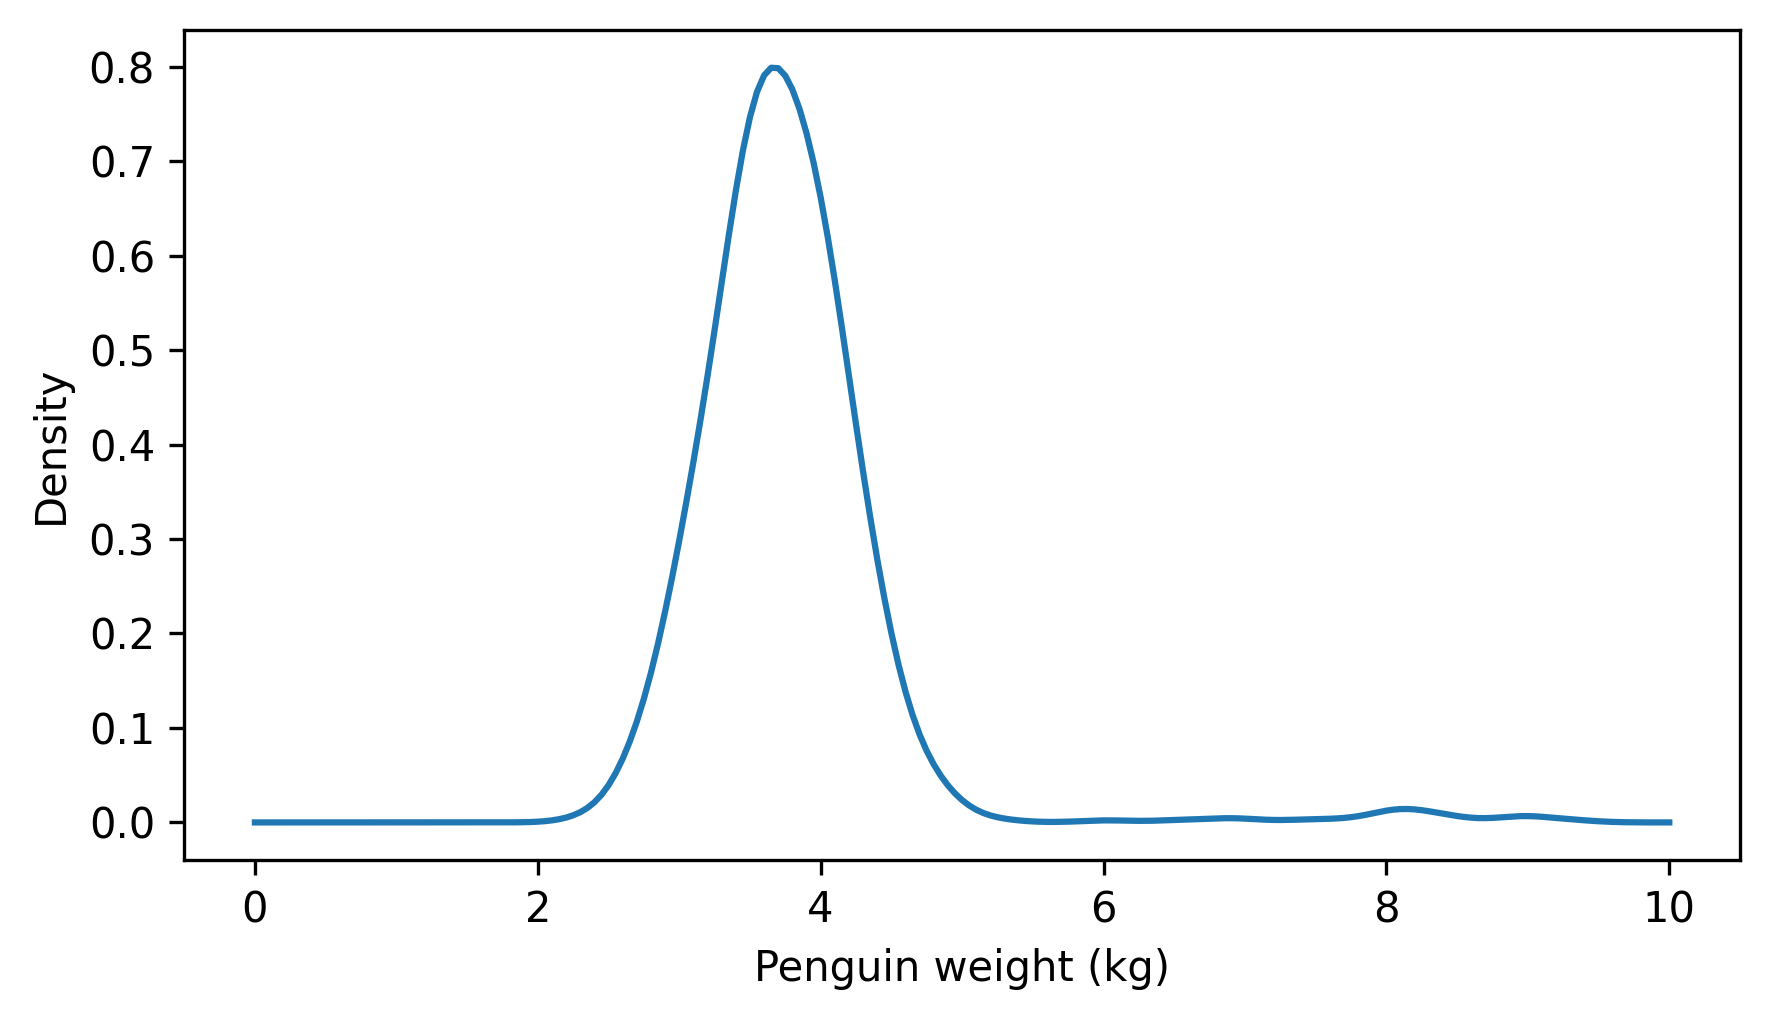

In [27]:
from scipy.stats import gaussian_kde
from thinkstats import Pdf

kde = gaussian_kde(sample)
domain = 0, 10
pdf = Pdf(kde, domain)
pdf.plot()
decorate(xlabel="Penguin weight (kg)", ylabel="Density")

In addition to the mode near 3.7 kg, the measurement errors introduce a second mode near 8 kilograms.

Now let's repeat the previous experiment, simulating many samples with size 10, computing the mean of each sample, and then computing the average of the sample means.

In [28]:
means = [np.mean(make_sample_with_errors(n=10)) for i in range(10001)]
np.mean(means)

3.786352945690677

The measurement errors cause the sample mean to be higher, on average, than 3.7 kg.

Now here's the same experiment using sample medians.

In [29]:
medians = [np.median(make_sample_with_errors(n=10)) for i in range(10001)]
np.mean(medians)

3.7121869836715353

The average of the sample medians is also higher than 3.7 kg, but it is not off by nearly as much.
If we compare the MSE of the estimates, we see that the sample medians are substantially more accurate.

In [30]:
mse(means, mu), mse(medians, mu)

(0.06853430354724438, 0.031164467796883758)

If measurements actually come from a normal distribution, the sample mean minimizes MSE, but this scenario violates that assumption, so the sample mean doesn't minimize MSE.
The sample median is less sensitive to outliers, so it is less biased and its MSE is smaller.
Estimators that deal well with outliers -- and similar violations of assumptions -- are said to be **robust**.

(section_estimating_variance)=
## Estimating Variance

As another example, suppose we want to estimate variance in the penguins' weights.
In [Chapter 1](section_summary_statistics), we saw that there are two ways to compute the variance of a sample.
I promised to explain the difference later -- and later is now.

The reason there are two ways to compute the variance of a sample is that one is a biased estimator of the population variance, and the other is unbiased.
The following function computes the biased estimator, which is the sum of the squared deviations divided by `n`.

In [31]:
def biased_var(xs):
    # Compute variance with n in the denominator
    n = len(xs)
    deviations = xs - np.mean(xs)
    return np.sum(deviations**2) / n

To test it, we'll simulate many samples with size 10, compute the biased variance of each sample, and then compute the average of the variances.

In [32]:
biased_vars = [biased_var(make_sample(n=10)) for i in range(10001)]
np.mean(biased_vars)

0.19049277659404473

The result is about 0.19, but in this case, we know that the actual population variance is about 0.21, so the biased sample variance is too low on average -- which confirms that it is biased.

In [33]:
actual_var = sigma**2
actual_var

0.2116

The following function computes the unbiased estimator, which is the sum of the squared deviations divided by `n-1`.

In [34]:
def unbiased_var(xs):
    # Compute variance with n-1 in the denominator
    n = len(xs)
    deviations = xs - np.mean(xs)
    return np.sum(deviations**2) / (n - 1)

We can test it by generating many samples and computing the unbiased variance for each one.

In [35]:
unbiased_vars = [unbiased_var(make_sample(n=10)) for i in range(10001)]
np.mean(unbiased_vars)

0.21159109492300626

The average of the unbiased sample variances is very close to the actual value -- which is what we expect if it is unbiased.

With sample size 10, the difference between the biased and unbiased estimators is about 10%, which might be non-negligible.
With sample size 100, the difference is only 1%, which is small enough that is probably doesn't matter in practice.

In [36]:
n = 10
1 - (n - 1) / n

0.09999999999999998

In [37]:
n = 100
1 - (n - 1) / n

0.010000000000000009

(section_sampling_distributions)=
## Sampling Distributions

So far we've been working with simulated data, assuming that penguin weights are drawn from a normal distribution with known parameters.
Now let's see what happens with real data.

Between 2007 and 2010, researchers at Palmer Station in Antarctica measured and weighed 342 penguins from local populations.
The data they collected is freely available -- instructions for downloading it are in the notebook for this chapter.

The following cell downloads the data from a repository created by Allison Horst.

Horst AM, Hill AP, Gorman KB (2020). palmerpenguins: Palmer Archipelago (Antarctica) penguin data. R package version 0.1.0. https://allisonhorst.github.io/palmerpenguins/. doi: 10.5281/zenodo.3960218.

The data was collected as part of the research that led to this paper: Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081

In [38]:
download(
    "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins_raw.csv"
)

Downloaded penguins_raw.csv


We can use Pandas to read the data.

In [39]:
penguins = pd.read_csv("penguins_raw.csv").dropna(subset=["Body Mass (g)"])
penguins.shape

(342, 17)

The dataset includes three penguins species.

In [40]:
penguins["Species"].value_counts()

,count
Species,
Adelie Penguin (Pygoscelis adeliae),151
Gentoo penguin (Pygoscelis papua),123
Chinstrap penguin (Pygoscelis antarctica),68


For the first example we'll select just the Chinstrap penguins.

In [41]:
chinstrap = penguins.query('Species.str.startswith("Chinstrap")')

We'll use this function to plot estimated PDFs.

In [43]:
def plot_kde(sample, name="", **options):
    kde = gaussian_kde(sample)
    m, s = np.mean(sample), np.std(sample)
    plt.axvline(m, ls=":", color="0.3")

    domain = m - 4 * s, m + 4 * s
    pdf = Pdf(kde, domain, name)
    pdf.plot(**options)

Here's the distribution of chinstrap penguin weights in kilograms.
The vertical dotted line shows the sample mean.

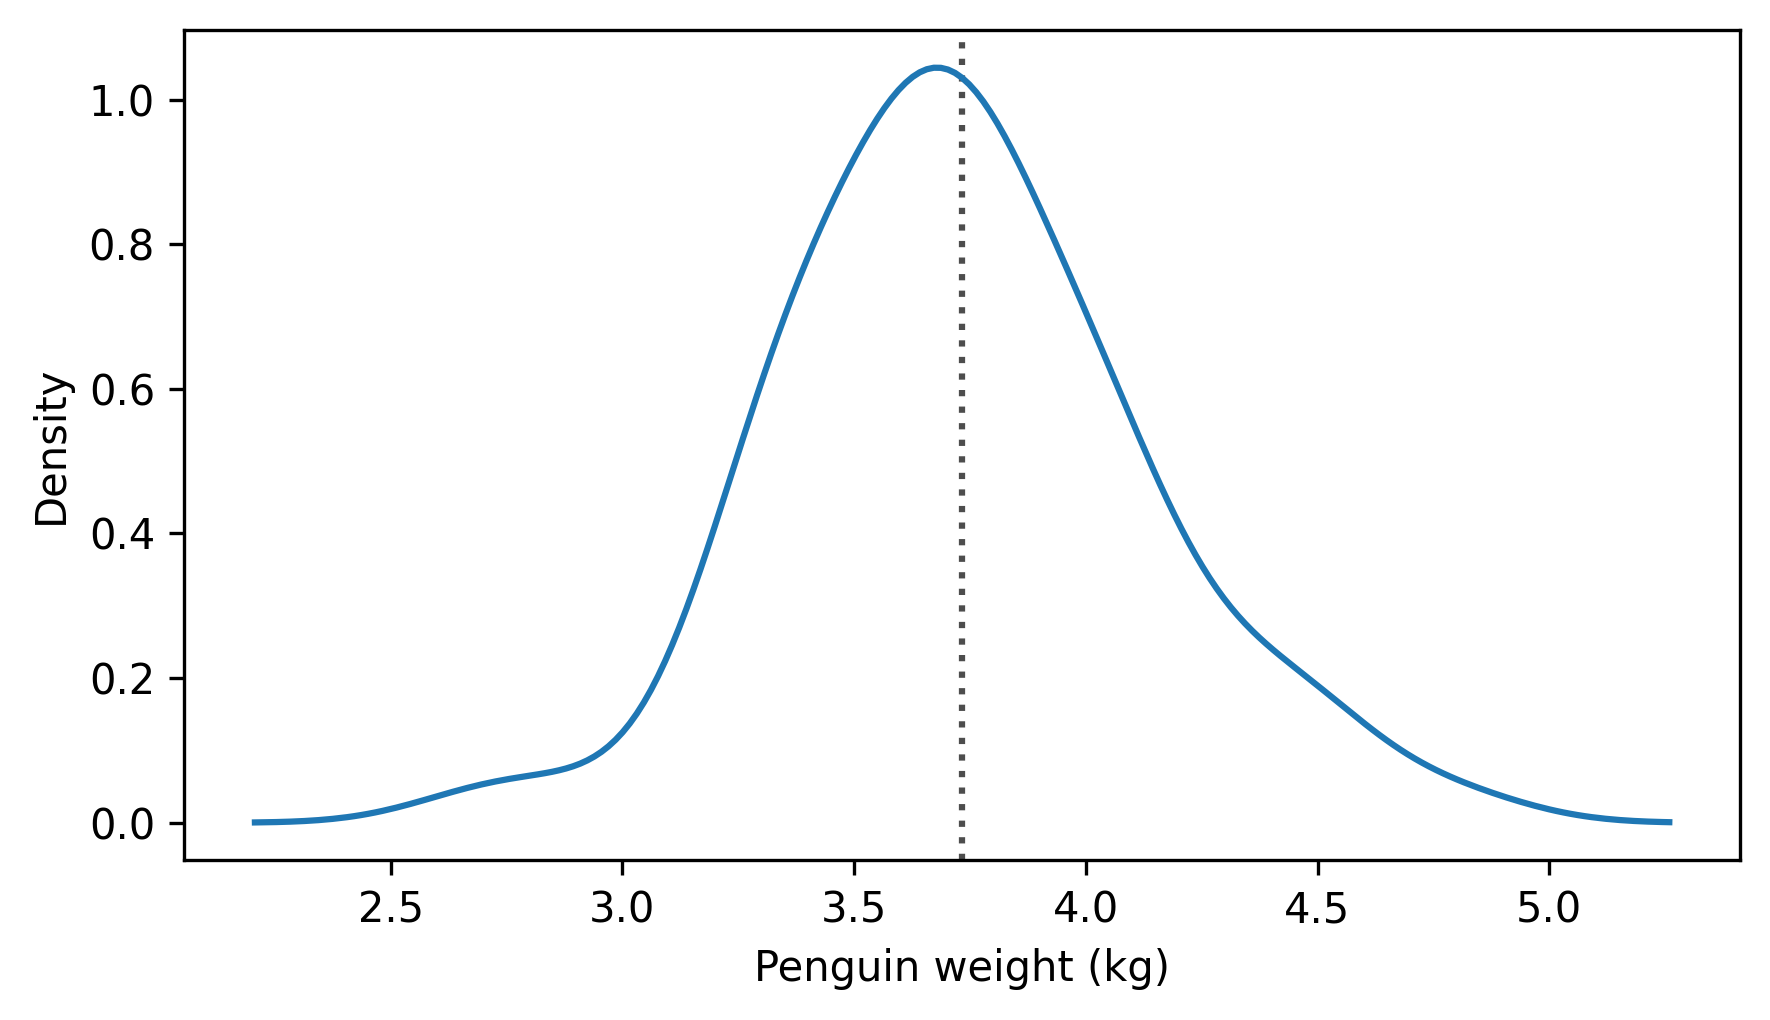

In [44]:
weights = chinstrap["Body Mass (g)"] / 1000
plot_kde(weights)
decorate(xlabel="Penguin weight (kg)", ylabel="Density")

The sample mean is about 3.7 kg.

In [45]:
sample_mean = np.mean(weights)
sample_mean

3.733088235294118

If you are asked to estimate the population mean, 3.7 kg is a reasonable choice -- but how precise is that estimate?

One way to answer that question is to compute the **sampling distribution** of the mean, which shows how much the estimated mean varies from one sample to another.
If we knew the actual mean and standard deviation in the population, we could model the sampling process and compute the sampling distribution.
But if we knew the actual population mean, we wouldn't have to estimate it!

Fortunately, there's a simple way to approximate the sampling distribution, called **resampling**.
The core idea is to use the sample to make a model of the population, then use the model to simulate the sampling process.

More specifically, we'll use **parametric resampling**, which means we'll use the sample to estimate the parameters of the population and then use a theoretical distribution to generate new samples.

The following function implements this process with a normal distribution.
Notice that the new samples are the same size as the original.

In [47]:
def resample(sample):
    # Generate a sample from a normal distribution
    m, s = np.mean(sample), np.std(sample)
    return np.random.normal(m, s, len(sample))

This loop uses `resample` to generate many samples and compute the mean of each one.

In [48]:
sample_means = [np.mean(resample(weights)) for i in range(1001)]

The following figure shows the distribution of these sample means.

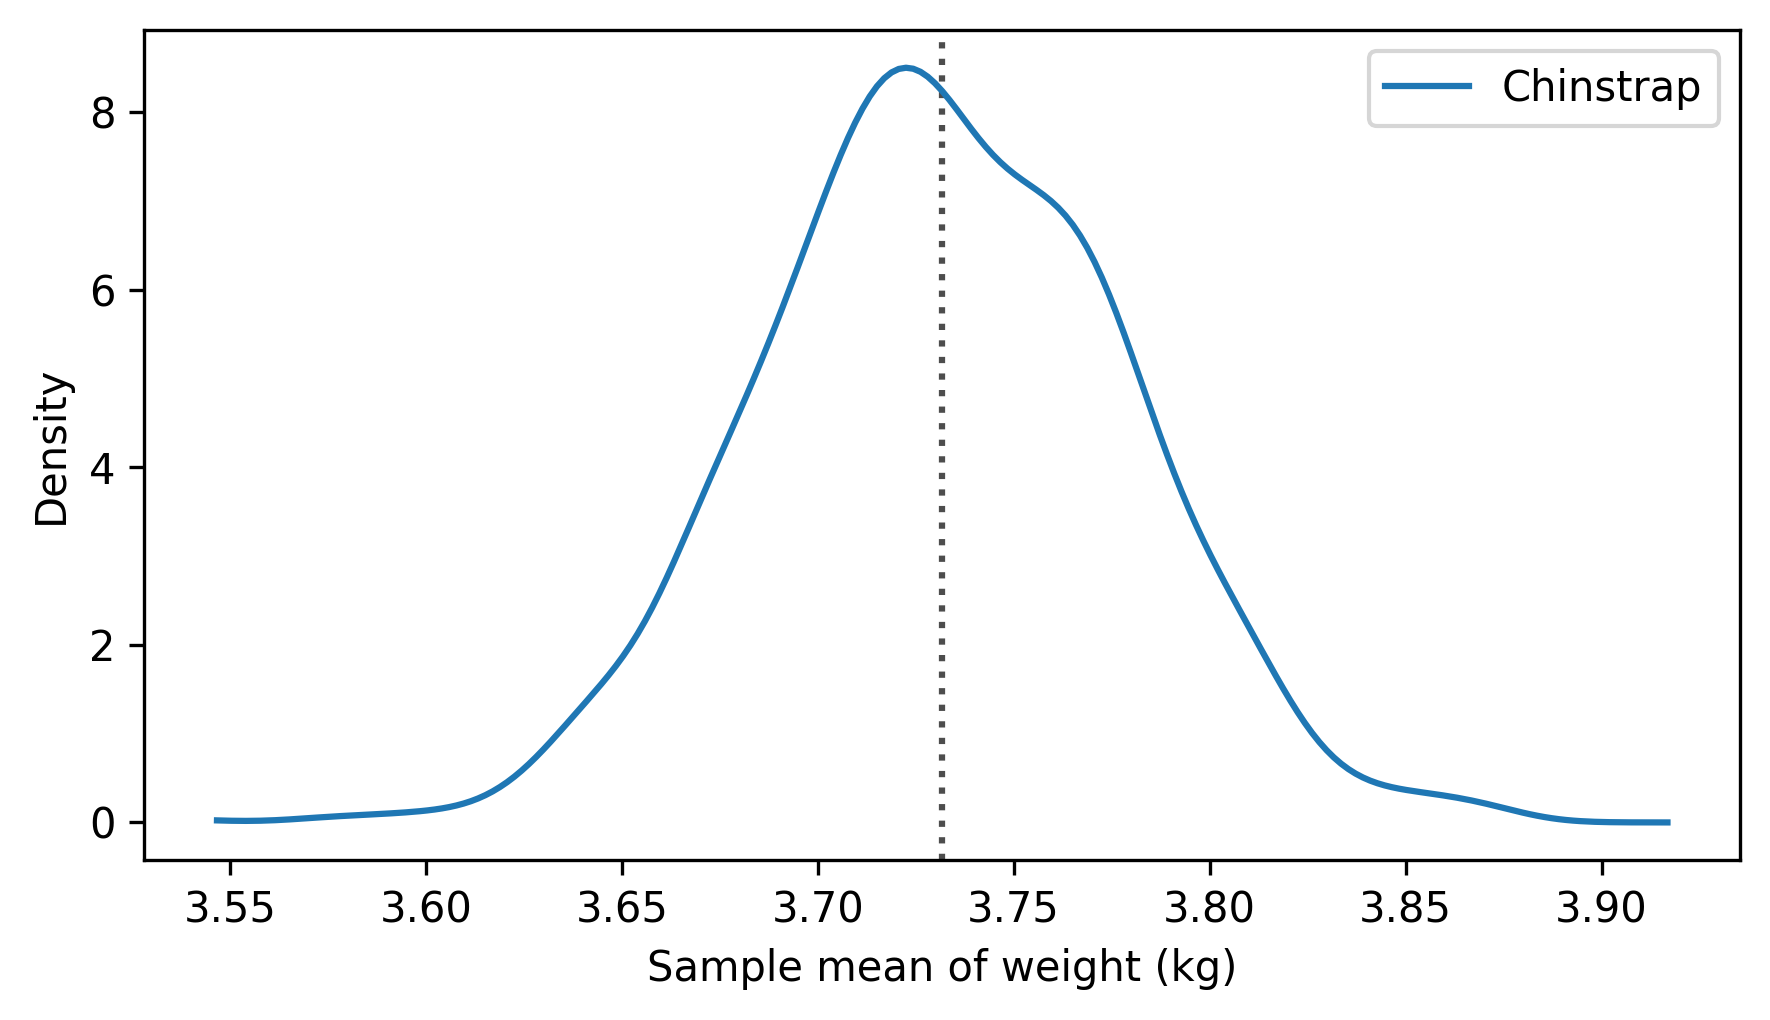

In [49]:
plot_kde(sample_means, "Chinstrap")
decorate(xlabel="Sample mean of weight (kg)", ylabel="Density")

This result approximates the sampling distribution of the sample mean.
It shows how much we expect the sample mean to vary if we collect many samples of the same size -- assuming that our model of the population is accurate.

Informally, we can see that the sample mean could be as low as 3.55, if we collected another sample with the same size, or as high as 3.9.

## Standard Error

To quantify the width of the sampling distribution, one option is to compute its standard deviation -- the result is called the **standard error**.

In [50]:
standard_error = np.std(sample_means)
standard_error

0.04626531069684985

In this case, the standard error is about 0.045 kg -- so if we collect many samples, we expect the sample means to vary by about 0.045 kg, on average.

People often confuse standard error and standard deviation. Remember:

* Standard deviation quantifies variation in measurements.

* Standard error quantifies the precision of an estimate.

In this dataset, the standard deviation of penguin weights is about 0.38 kg for chinstrap penguins.

In [51]:
np.std(weights)

0.3814986213564681

The standard error of the average weight is about 0.046 kg.

In [52]:
np.std(sample_means)

0.04626531069684985

Standard deviation tells you how much penguins differ in weight.
Standard error tells you how precise an estimate is.
They are answers to different questions.

However, there is a relationship between them.
If we know the standard deviation and sample size, we can approximate the standard error of the mean like this:

In [53]:
def approximate_standard_error(sample):
    n = len(sample)
    return np.std(sample) / np.sqrt(n)

In [54]:
approximate_standard_error(weights)

0.046263503290595163

This result is close to what we got by resampling.

## Confidence Intervals

Another way to summarize the sampling distribution is to compute a **confidence interval**.
For example, a 90% confidence interval contains 90% of the values in the sampling distribution, which we can find by computing the 5th and 95th percentiles.
Here's the 90% confidence interval for the average weight of chinstrap penguins.

In [55]:
ci90 = np.percentile(sample_means, [5, 95])
ci90

array([3.6576334 , 3.80737506])

In [57]:
ci100 = np.percentile(sample_means, [0, 100])
ci100

array([3.53520294, 3.87192817])

To interpret a confidence interval, it is tempting to say that there is a 90% chance that the true value of the population parameter falls in the 90% confidence interval.
In this example, we would say there is a 90% chance that the population mean for chinstrap penguins is between 3.66 and 3.81 kg.

Under a strict philosophy of probability called **frequentism**, this interpretation would not be allowed, and in many statistics books, you will be told that this interpretation is wrong.

In my opinion, this prohibition is unnecessarily strict.
Under reasonable philosophies of probability, a confidence interval means what people expect it to mean: there is a 90% chance that the true value falls in the 90% confidence interval.

However, confidence intervals only quantify variability due to sampling -- that is, measuring only part of the population.
The sampling distribution does not account for other sources of error, notably sampling bias and measurement error, which are the topics of the next section.

## Sources of Error

Suppose that instead of the average weight of penguins in Antarctica, you want to know the average weight of women in the city where you live.
You can't randomly choose a representative sample of women and weigh them.

A simple alternative would be "telephone sampling" -- that is, you could choose random numbers from the phone book, call and ask to speak to an adult woman, and ask how much she weighs.
But telephone sampling has obvious problems.

For example, the sample is limited to people whose telephone numbers are listed, so it eliminates people without phones (who might be poorer than average) and people with unlisted numbers (who might be richer).
Also, if you call home telephones during the day, you are less likely to sample people with jobs.
And if you only sample the person who answers the phone, you are less likely to sample people who share a phone line.

If factors like income, employment, and household size are related to weight -- and it is plausible that they are -- the results of your survey would be affected one way or another.
This problem is called **sampling bias** because it is a property of the sampling process.

This sampling process is also vulnerable to self-selection, which is a kind of sampling bias.
Some people will refuse to answer the question, and if the tendency to refuse is related to weight, that would affect the results.

Finally, if you ask people how much they weigh, rather than weighing them, the results might not be accurate.
Even helpful respondents might round up or down if they are uncomfortable with their actual weight.
And not all respondents are helpful.
These inaccuracies are examples of **measurement error**.

When you report an estimated quantity, it is useful to quantify variability due to sampling by reporting a standard error or a confidence interval.
But remember that this variability is only one source of error, and often it is not the biggest.

## Glossary

-   **population mean:** The true mean of a quantity in an entire population, as opposed to the sample mean, which is calculated from a subset.

-   **parameter**: One of the values that specifies a particular distribution in a set of distributions -- for example, the parameters of a normal distribution are the mean and standard deviation.

-   **estimator**: A statistic calculated from a sample that is used to estimate a parameter of the population.

-   **consistent:** An estimator is consistent if it converges to the actual value of the parameter as the sample size increases.

-   **unbiased:** An estimator is unbiased if, for a particular sample size, the average of the sample estimates is the actual value of the parameter.

-   **mean squared error (MSE)**: A measure of the accuracy of an estimator -- it's the average squared difference between estimated and true parameter values, assuming the true value is known.

-   **robust:** An estimator is robust if it remains accurate even when a dataset contains outliers or errors -- or does not perfectly follow a theoretical distribution.

-   **resampling:** A way to approximate the sampling distribution of an estimate by simulating the sampling process.

-   **sampling distribution**: The distribution of a statistic across possible samples from the same population.

-   **parametric resampling:** A kind of resampling that estimates population parameters from sample data and then uses a theoretical distribution to simulate the sampling process."

-   **standard error**: The standard deviation of a sampling distribution, which quantifies the variability of an estimate due to random sampling (but not measurement error or non-representative sampling).

-   **confidence interval**: An interval that contains the most likely values of a sample drawn from a population.

## Exercises

### Exercise 8.1

One of the strengths of resampling methods is that they are easy to extend to other statistics.
In this chapter, we computed the sample mean of penguin weights and then used resampling to approximate the sampling distribution of the mean.
Now let's do the same for standard deviation.

Compute the sample standard deviation of weights for chinstrap penguins.
Then use `resample` to approximate the sampling distribution of the standard deviation.
Use the sampling distribution to compute the standard error of the estimate and a 90% confidence interval.

In [59]:
sample_std = [np.std(resample(weights)) for i in range(1001)]

In [72]:
np.array(sample_std).std()

0.032684932370903814

In [73]:
np.percentile(sample_std, [5, 95])


array([0.32584783, 0.43552134])

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

### Exercise 8.2

The Behavioral Risk Factor Surveillance System (BRFSS) dataset includes self-reported heights and weights for a sample of adults in the United States.
Use this data to estimate the average height of male adults.
Use resample to approximate the sampling distribution and compute a 90% confidence interval.

Because the sample size is very large, the confidence interval is very small, which means that variability due to random sampling is small.
But other sources of error might be bigger -- what other sources of error do you think affect the results?

The following cells download the data, read it into a `DataFrame`, and select the heights of male respondents.

In [74]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/CDBRFS08.ASC.gz")

Downloaded CDBRFS08.ASC.gz


In [75]:
from thinkstats import read_brfss

brfss = read_brfss()

In [76]:
male = brfss.query("sex == 1")
heights = male["htm3"]
heights.describe()

,htm3
count,154407.000000
mean,178.066221
std,7.723563
min,61.000000
25%,173.000000
50%,178.000000
75%,183.000000
max,236.000000


In [77]:
sample_h_means = [np.mean(resample(heights)) for i in range(1001)]

In [78]:
np.std(sample_h_means)

0.019314703012963515

In [80]:
approximate_standard_error(heights)# Solution goes here

0.01957346990388111

In [81]:
np.percentile(sample_h_means, [0.5, 0.95])# Solution goes here

array([178.01070884, 178.01808633])

### Exercise 8.3

In games like soccer and hockey, the time between goals tends to follow an exponential distribution (as we saw in [Chapter 6](section_exponential_pdf)).
Suppose we observe a sample of times between goals.
If we assume that the sample came from an exponential distribution, how can we estimate the actual mean of the distribution?
We might consider using either the sample mean or the sample median.
Let's see if either of them is a consistent, unbiased estimator.
For the experiments, we'll assume that the actual mean time between goals is 10 minutes.

In [84]:
actual_mean = 10

The following function generates a sample from an exponential distribution with this mean and the given sample size.

In [85]:
def make_exponential(n):
    return np.random.exponential(actual_mean, size=n)

Use this function to generate samples with a range of sizes and compute the mean of each one. As `n` increases, do the sample means converge to the actual mean?

Next, generate samples with a range of sizes and compute the median of each one.
Do the sample medians converge to the actual median?

Here's the actual median of an exponential distribution with the given mean.

In [86]:
actual_median = np.log(2) * actual_mean
actual_median

6.931471805599453

In [117]:
e_medians = [np.median(make_exponential(i)) for i in range(1001)]
e_medians[-1]

6.55347479754268

In [118]:
e_means = [np.mean(make_exponential(i)) for i in range(1001)]
e_means[-1]

10.344797717614968

Next, generate many samples with size 10 and check whether the sample mean is an unbiased estimator of the population mean.

In [107]:
e_10_means = [np.mean(make_exponential(10)) for i in range(1001)]
np.mean(e_10_means), np.median(e_10_means), np.std(e_10_means)

(10.200330870719336, 9.805241897671678, 3.1483590332521305)

In [113]:
unbiased_var(e_10_means)

9.922076766862551

Finally, check whether the sample median is an unbiased estimator of the population median.

In [124]:
e_10_medians = [np.median(make_exponential(10)) for i in range(1001)]
np.mean(e_10_medians), np.median(e_10_medians), np.std(e_10_medians)

(7.778295122557174, 7.289851348078468, 3.1343035956623857)

In [125]:
unbiased_var(e_10_medians)

9.833682888811941

### Exercise 8.4

In this chapter we tested a biased estimator of variance and showed that it is, in fact, biased.
And we showed that the unbiased estimator is unbiased.
Now let's try standard deviation.

To estimate the standard deviation of a population, we can compute the square root of the biased or unbiased estimator of variance, like this:

In [126]:
def biased_std(sample):
    # Square root of the biased estimator of variance
    var = biased_var(sample)
    return np.sqrt(var)

In [127]:
def unbiased_std(sample):
    # Square root of the unbiased estimator of variance
    var = unbiased_var(sample)
    return np.sqrt(var)

Use `make_sample` to compute many samples of size 10 from a normal distribution with mean 3.7 and standard deviation 0.46.
Check whether either of these is an unbiased estimator of standard deviation.

In [128]:
# Here's an example using `make_sample`

mu, sigma = 3.7, 0.46
make_sample(n=10)

array([4.5279695 , 3.07713037, 3.28570008, 3.61539724, 3.96480147,
       3.98231597, 3.21935205, 3.72497692, 3.51937961, 3.77155228])

In [133]:
std_norm_10 = [np.std(make_sample(10)) for i in range(1001)]
np.mean(std_norm_10), np.median(std_norm_10), np.std(std_norm_10)


(0.428811475056443, 0.4272875550707438, 0.10319580838672732)

In [134]:
biased_std(std_norm_10), unbiased_std(std_norm_10)

(0.10319580838672732, 0.10324739339789034)

In [ ]:
# Solution goes here

### Exercise 8.5

This exercise is based on the German tank problem, which a simplified version of an actual analysis performed by the Economic Warfare Division of the American Embassy in London during World War II.

Suppose you are an Allied spy and your job is to estimate how many tanks the Germans have built.
As data, you have serial numbers recovered from `k` captured tanks.

If we assume that the Germans have `N` tanks numbered from 1 to `N`, and that all tanks in this range were equally likely to be captured, we can estimate `N` like this:

In [136]:
def estimate_tanks(sample):
    m = np.max(sample)
    k = len(sample)
    return m + (m - k) / k

As an example, suppose `N` is 122.

In [135]:
N = 122
tanks = np.arange(1, N + 1)

We can use the following function to generate a random sample of `k` tanks.

In [137]:
def sample_tanks(k):
    return np.random.choice(tanks, replace=False, size=k)

Here's an example.

In [138]:
np.random.seed(17)

In [139]:
sample = sample_tanks(5)
sample

array([74, 71, 95, 10, 17])

And here is the estimate based on this sample.

In [140]:
estimate_tanks(sample)

113.0

Check whether this estimator is biased.

In [154]:
t = [estimate_tanks(sample_tanks(5)) for i in range(N)]
np.mean(t), np.median(t), np.std(t)

(120.94754098360654, 126.2, 22.16545537511073)

In [155]:
biased_std(t), unbiased_std(t)

(22.16545537511073, 22.25685970258654)

For more on this problem, see [this Wikipedia page][https://en.wikipedia.org/wiki/German_tank_problem] and Ruggles and Brodie, "An Empirical Approach to Economic Intelligence in World War II", Journal of the American Statistical Association, March 1947, available [here](https://web.archive.org/web/20170123132042/https://www.cia.gov/library/readingroom/docs/CIA-RDP79R01001A001300010013-3.pdf).

For an explanation of how this estimator works, you might like [this video](https://www.youtube.com/watch?v=WLCwMRJBhuI).

### Exercise 8.6

In several sports -- especially basketball -- many players and fans believe in a phenomenon called the "hot hand", which implies that a player who has hit several consecutive shots is more likely to hit the next, and a player who has missed several times is more likely to miss.

A famous paper proposed a way to test whether the hot hand is real or an illusion, by looking at sequences of hits and misses from professional basketball games.
For each player, the authors computed the overall probability of making a shot, and the conditional probability of making a shot after three consecutive hits.
For eight out of nine players, they found that the probability of making a shot was *lower* after three hits.
Based on this and other results, they concluded that there is "no evidence for a positive correlation between the outcomes of successive shots".
And for several decades, many people believed that the hot hand had been debunked.

However, this conclusion is based on a statistical error, at least in part.
A 2018 paper showed that the statistic used in the first paper -- the probability of making a shot after three hits -- is biased.
Even if the probability of making every shot is exactly 0.5, and there is actually no correlation between the outcomes, the probability of making a shot after three hits is *less than 0.5*.

It is not obvious why that's true, which is why the error went undetected for so long, and I won't try to explain it here.
But we can use the methods from this chapter to check it.
We'll use the following function to generate a sequence of 0s and 1s with probability 0.5 and no correlation.

In [156]:
def make_hits_and_misses(n):
    # Generate a random sequence of 0s and 1s
    return np.random.choice([0, 1], size=n)

In the notebook for this chapter, I provide a function that finds all subsequences of three hits (1s) and returns the element of the sequence that follows.

In [157]:
import numpy as np


def get_successors(seq, target_sum=3):
    """Get the successors of each subsequence that sums to a target value.

    Parameters:
    seq (array-like): Sequence of 1s and 0s.
    target_sum (int): The target sum of the subsequence. Default is 3.

    Returns:
    np.ndarray: Array of successors to subsequences that sum to `target_sum`.
    """
    # Check if the input sequence is too short
    if len(seq) < 3:
        return np.array([])

    # Compute the sum of each subsequence of length 3
    kernel = [1, 1, 1]
    corr = np.correlate(seq, kernel, mode="valid")

    # Find the indices where the subsequence sums to the target value
    indices = np.nonzero(corr == target_sum)[0]

    # Remove cases where the subsequence is at the end of the sequence
    indices = indices[indices < len(seq) - 3]

    # Find the successors of each valid subsequence
    successors = seq[indices + 3] if len(indices) > 0 else np.array([])

    return successors

Generate a large number of sequences with length 100 and for each sequence, find each shot that follows three hits.
Compute the percentage of these shots that are hits.
Hint: if the sequence does not contain three consecutive hits, the function returns an empty sequence, so your code will have to handle that.

If you run this simulation many times, what is the average percentage of hits?
How does this result vary as you increase or decrease the length of the sequence.

In [177]:
def p_per_range(r):
  l = [get_successors(make_hits_and_misses(100)) for i in range(r)]
  p = [sum(i)/ len(i) * 100 for i in l if len(i) > 0]
  return np.mean(p)


In [179]:
pp = [p_per_range(i) for i in range(1000)]

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


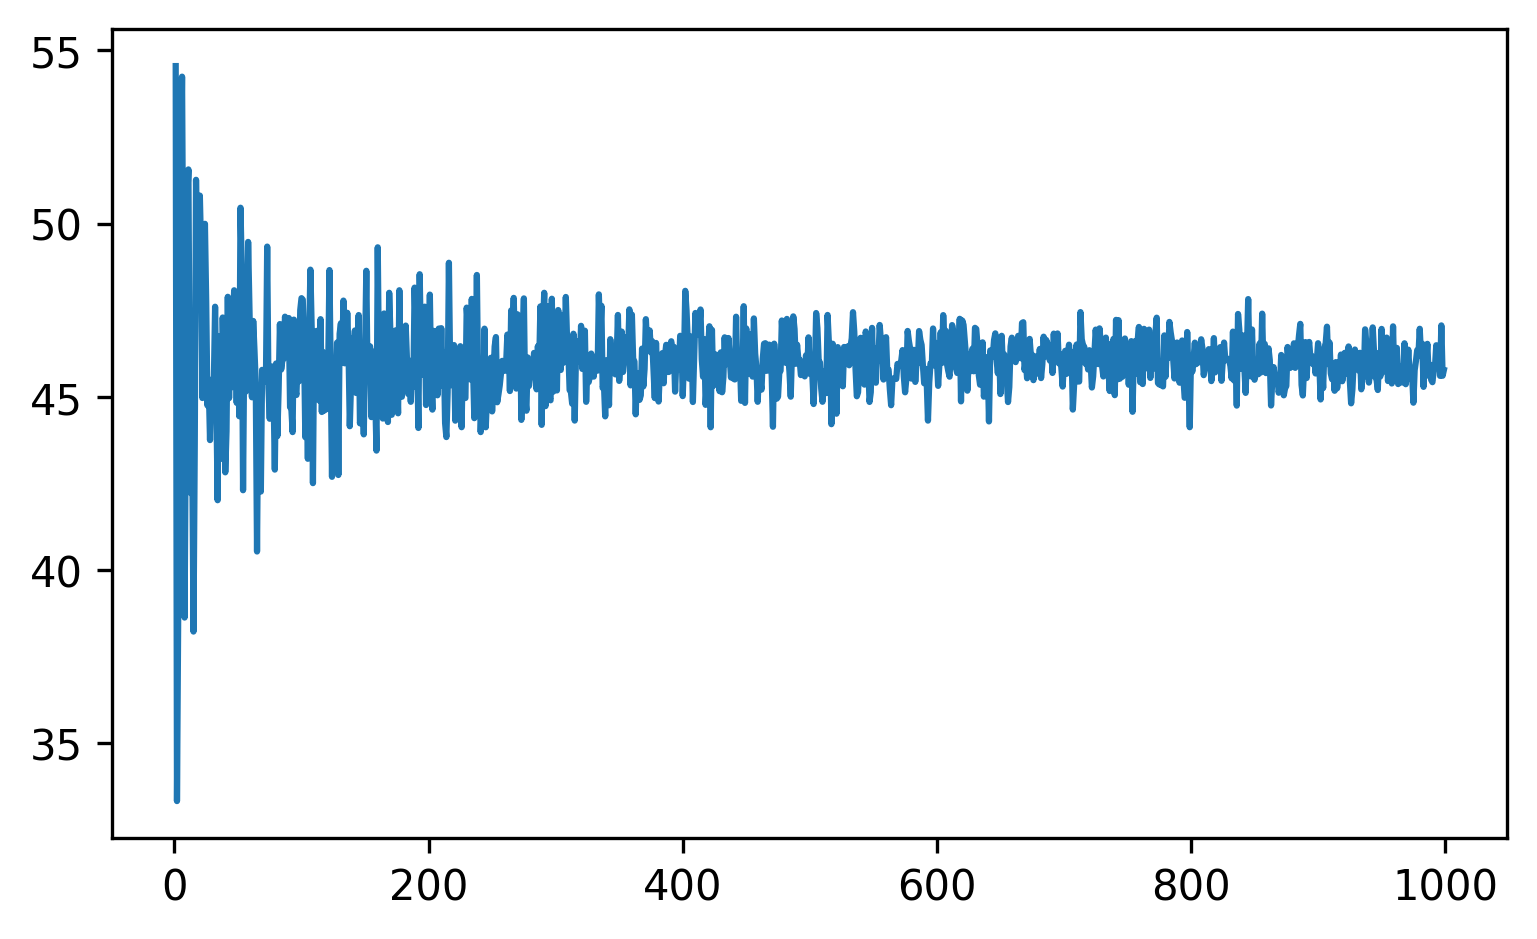

In [180]:
plt.plot(pp)

In [184]:
biased_var(pp[1:]), unbiased_var(pp[1:])

(1.5487683958939231, 1.5503202680340975)

In [186]:
np.percentile(pp[1:], [0.5,0.95])# Solution goes here

array([42.00104063, 42.5968212 ])

In [ ]:
# Solution goes here

The famous paper is Gilovich, T., Vallone, R., & Tversky, A. (1985). The hot hand in basketball: On the misperception of random sequences. *Cognitive psychology*, 17(3), 295-314.

The paper showing the statistical error is Miller, J. B., & Sanjurjo, A. (2018). Surprised by the hot hand fallacy? A truth in the law of small numbers. *Econometrica*, 86(6), 2019-2047.

The first paper is [available here](https://www.joelvelasco.net/teaching/122/Gilo.Vallone.Tversky.pdf).
The second is [available here](https://marketing.wharton.upenn.edu/wp-content/uploads/2018/11/Paper-Joshua-Miller.pdf).
For an overview of the topic and an explanation of the error, [you might like this video](https://www.youtube.com/watch?v=CR5vT44ZMK8).

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)